In [1]:
from typing import Any, Iterable, List, Tuple
import torch
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import numpy as np

In [19]:
import sys
sys.path.append("../src")
from explainer import Archipelago
from application_utils.text_utils import TextXformer
from viz.text import viz_text

In [3]:
GPT2_PATH = "gpt_model"


def download_models() -> None:
    tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained('gpt2-large')
    tokenizer.save_pretrained(GPT2_PATH)
    model.save_pretrained(GPT2_PATH)


def load_model_from_file() -> Tuple[Any, Any]:
    tokenizer = GPT2TokenizerFast.from_pretrained('gpt_model')
    model = GPT2LMHeadModel.from_pretrained('gpt_model')
    return tokenizer, model

In [4]:
tokenizer, model = load_model_from_file()

In [5]:
class GPTWrapperTorch:
    def __init__(self, model: Any, device: str, merge_logits: bool = False) -> None:
        self.model = model

    def __call__(self, batch_ids: Iterable[Iterable[int]]) -> List[List[float]]:
        """
        Input: A batch of examples, where each example is a list of tokens
        - shape = (batch_size, sent_len)
        Output: For each example, the logits for the likelihood of for all 50257 tokens to be the next word
        - shape = (batch_size, 50257)
        """
        preds = model(torch.LongTensor(batch_ids)).logits  # (batch_size, sent_len, vocab_size)
        next_word_preds = preds[:, -1]  # (batch_size, vocab_size)
        return next_word_preds.detach().numpy()

In [79]:
# tokenizer, model = load_model_from_file()

def most_likely_next(sent: str, k: int = 10) -> None:
    tokens = tokenizer(sent).input_ids  # (sent_len,)
    preds = model(torch.LongTensor(tokens)).logits  # (sent_len, vocab_size)
    next_word_preds = preds[-1]
    next_word_tokens = torch.topk(next_word_preds, k=k).indices
    next_words = tokenizer.decode(next_word_tokens)
    print(next_words)

In [7]:
def explain_prediction(sent: str, next_word: str, top_k: int, add_space_before: bool = True) -> None:
    # Tokens generally have a space before them if they are coming next in a sentence
    if add_space_before and next_word[0] != ' ':
        next_word = f" {next_word}"
    next_word_tokens = tokenizer(next_word).input_ids
    next_word_token = next_word_tokens[0]
    print(f"Analyzing interactions wrt prediction: '{tokenizer.decode(next_word_token)}'")

    text_ids = tokenizer(sent).input_ids
    baseline_ids = tokenizer('_').input_ids * len(text_ids)
    output_indices = next_word_token

    model_wrapper = GPTWrapperTorch(model=model, device="cpu")
    xf = TextXformer(text_ids, baseline_ids)
    apgo = Archipelago(
        model_wrapper, 
        data_xformer=xf, 
        output_indices=output_indices,
        batch_size=1,
    )
    explanation = apgo.explain(top_k=top_k)

    sent_tokens = tokenizer(sent).input_ids
    sent_token_words = list(map(lambda t: tokenizer.decode(t).strip(), sent_tokens))
    viz_text(explanation, sent_token_words)

In [50]:
sent = "yesterday afternoon me and my son went to the"
most_likely_next(sent)

 store park local grocery beach mall gym library hospital school


In [51]:
num_tokens = len(tokenizer(sent).input_ids)

In [52]:
### EXPERIMENT 1

Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'
Analyzing interactions wrt prediction: ' store'


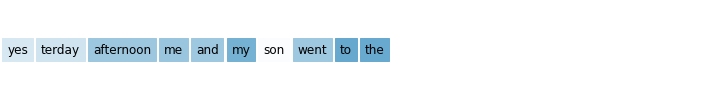

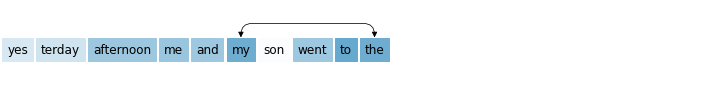

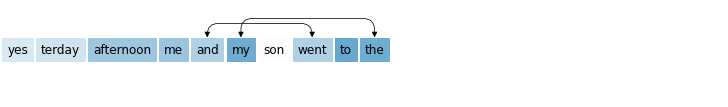

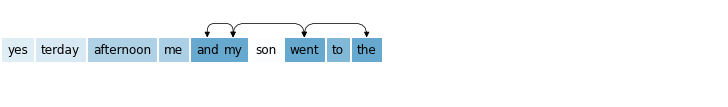

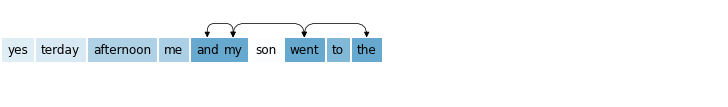

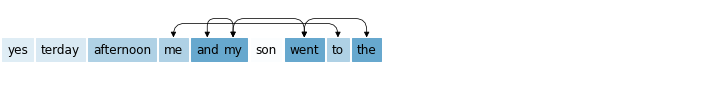

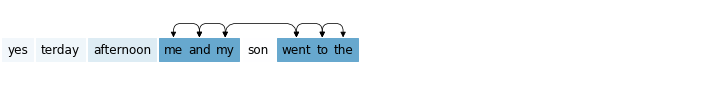

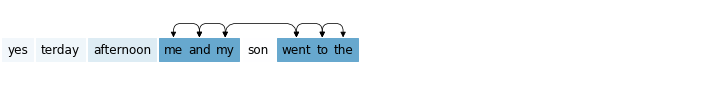

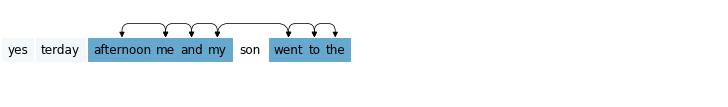

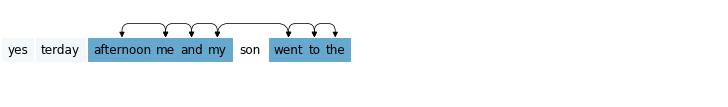

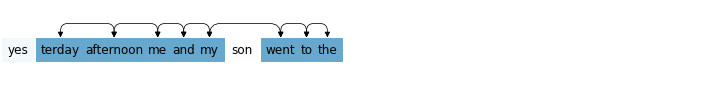

In [55]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="store", top_k=k)

In [56]:
sent_baseline = "_ _ me and my _ went to the"
most_likely_next(sent_baseline)

 _ house store same church shop place town other door


In [57]:
### EXPERIMENT 2

Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'
Analyzing interactions wrt prediction: ' park'


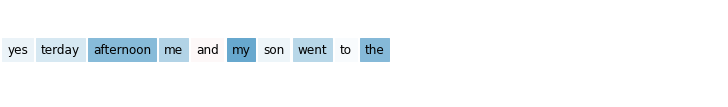

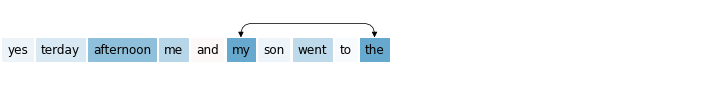

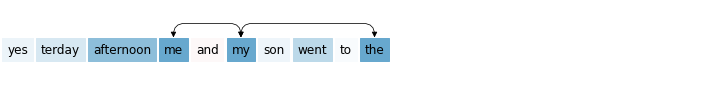

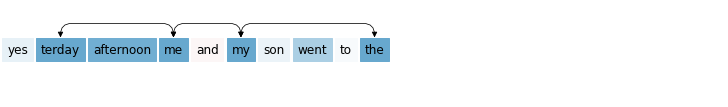

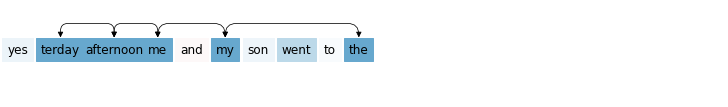

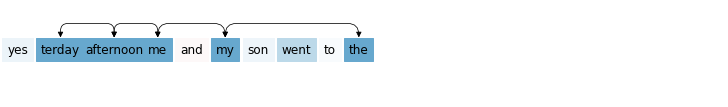

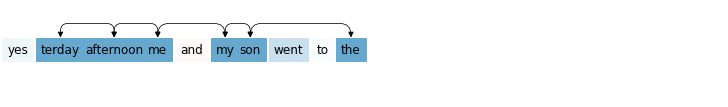

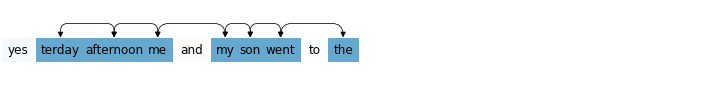

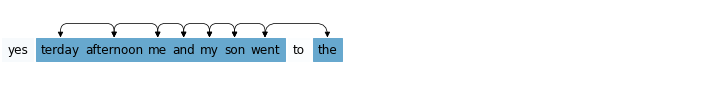

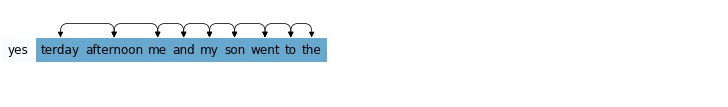

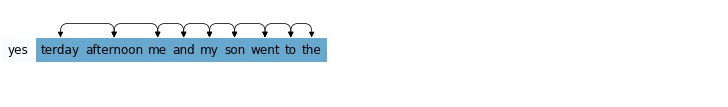

In [58]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="park", top_k=k)

In [82]:
sent_baseline = "_terday afternoon me _ my son went _ the"
most_likely_next(sent_baseline)

 _ store park other house mall bathroom school hospital bus


In [59]:
### EXPERIMENT 3

Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'
Analyzing interactions wrt prediction: ' local'


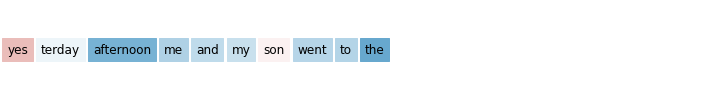

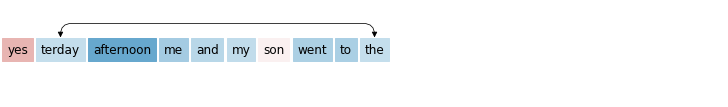

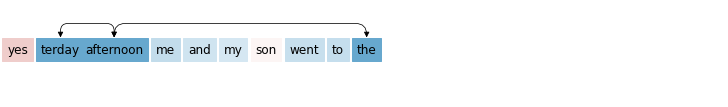

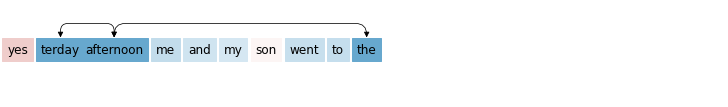

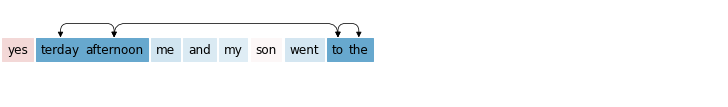

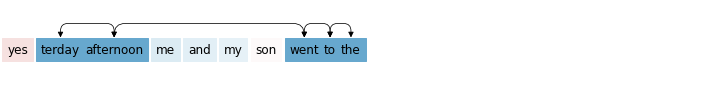

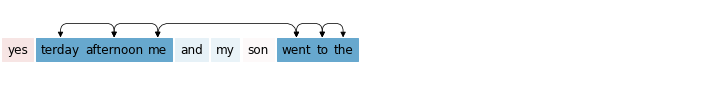

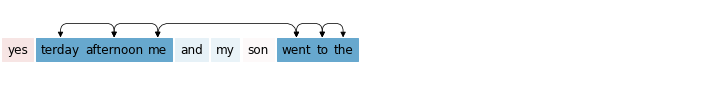

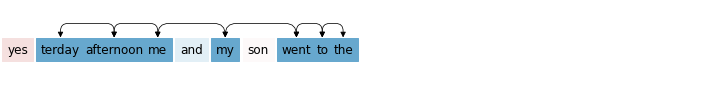

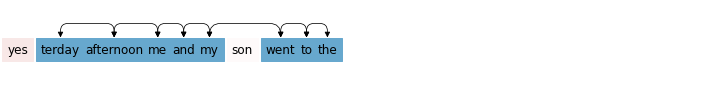

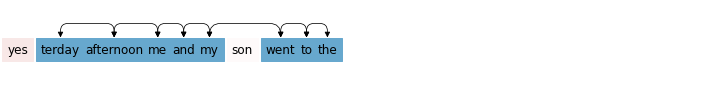

In [60]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="local", top_k=k)

In [61]:
### EXPERIMENT 4

Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'
Analyzing interactions wrt prediction: ' grocery'


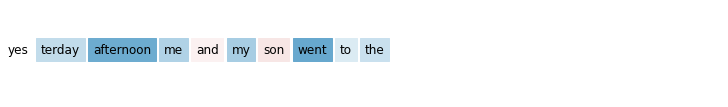

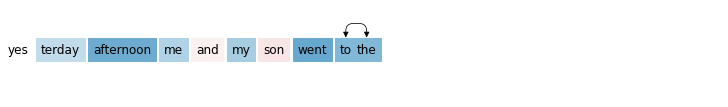

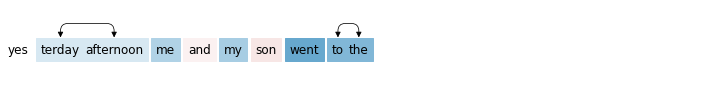

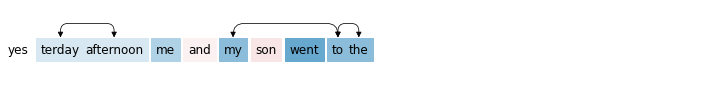

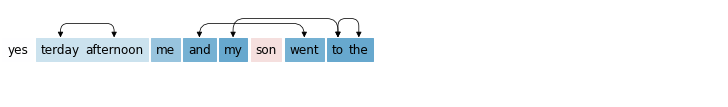

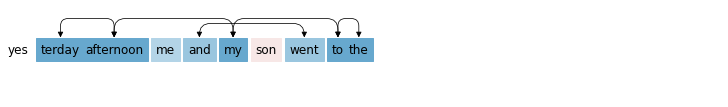

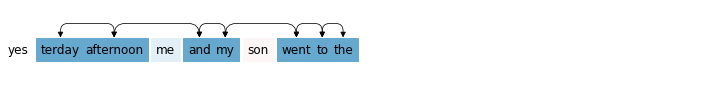

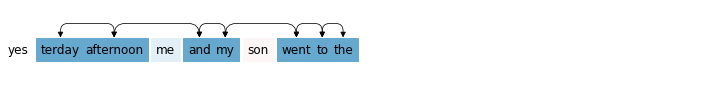

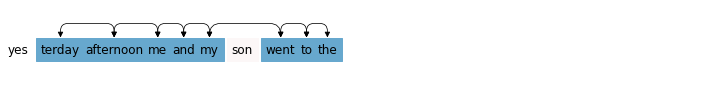

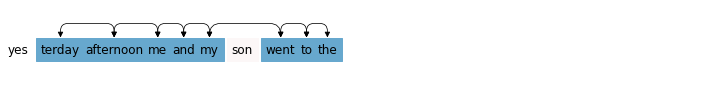

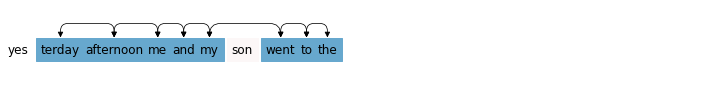

In [62]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="grocery", top_k=k)

In [63]:
### EXPERIMENT 5

Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'
Analyzing interactions wrt prediction: ' beach'


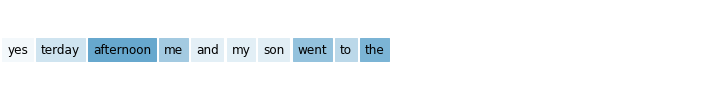

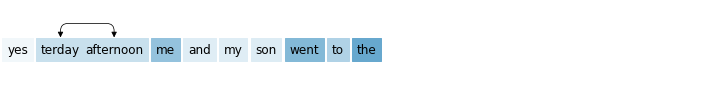

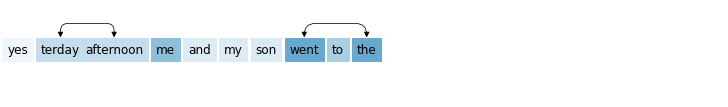

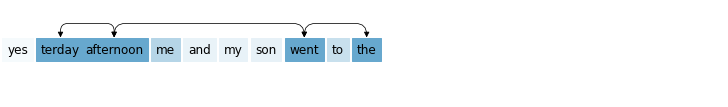

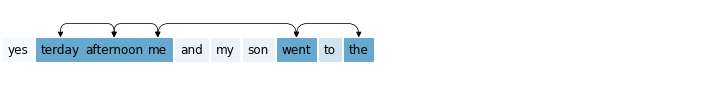

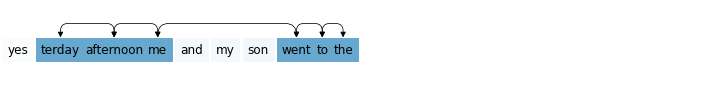

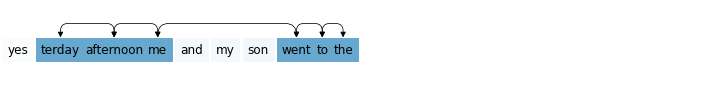

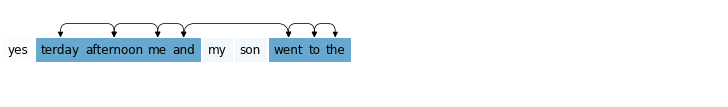

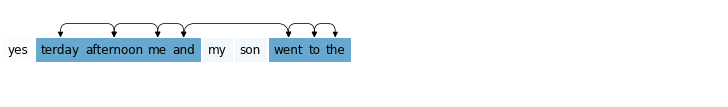

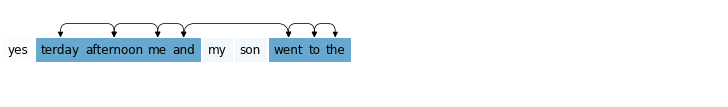

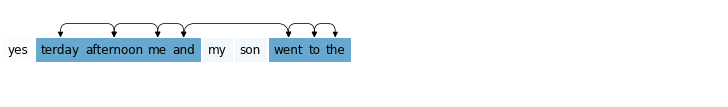

In [64]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="beach", top_k=k)

In [65]:
### EXPERIMENT 6

Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'
Analyzing interactions wrt prediction: ' mall'


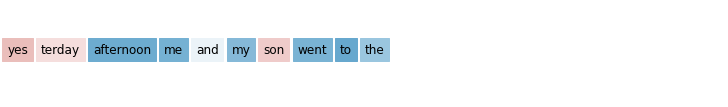

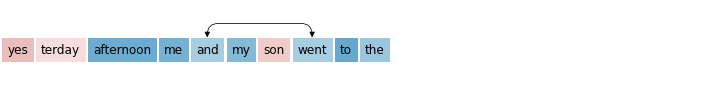

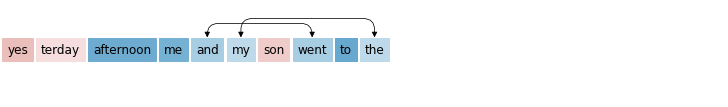

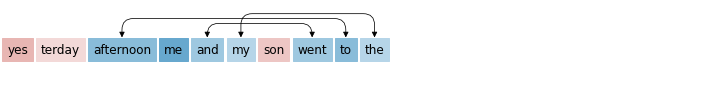

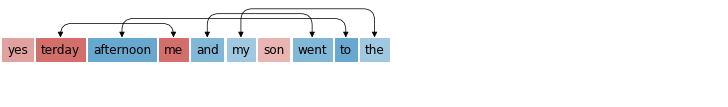

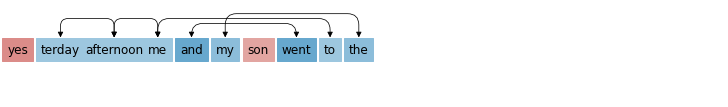

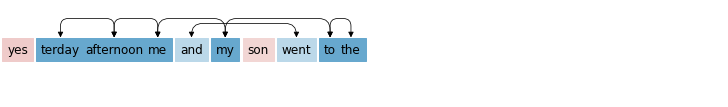

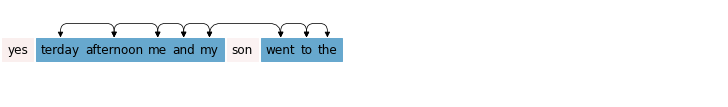

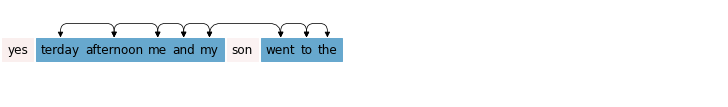

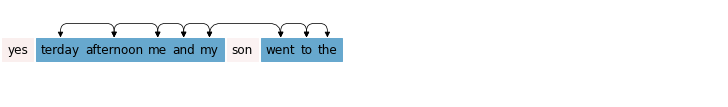

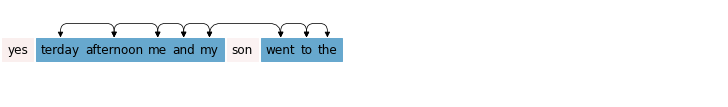

In [66]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="mall", top_k=k)

In [67]:
### EXPERIMENT 7

Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'
Analyzing interactions wrt prediction: ' gym'


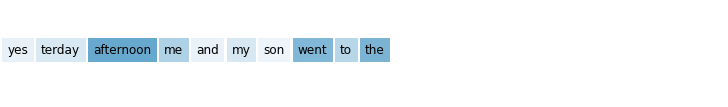

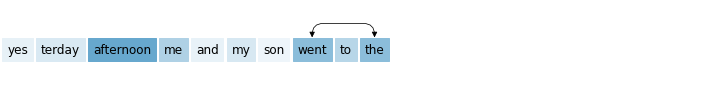

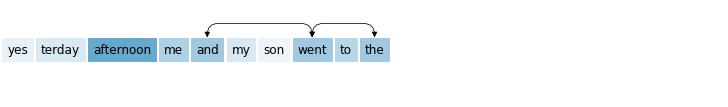

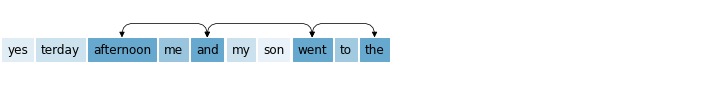

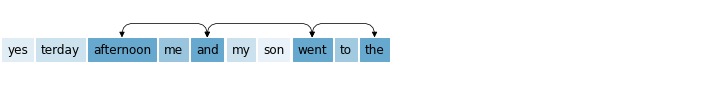

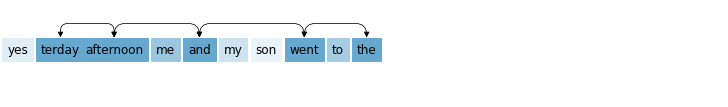

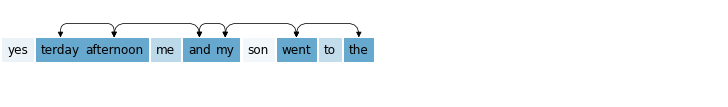

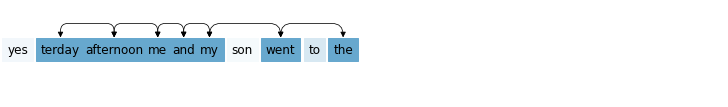

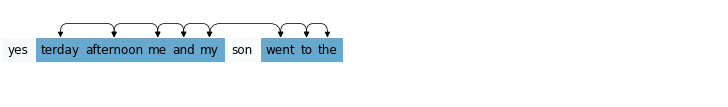

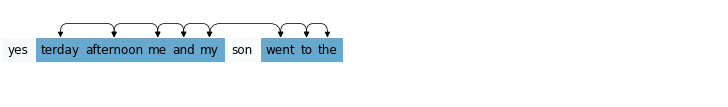

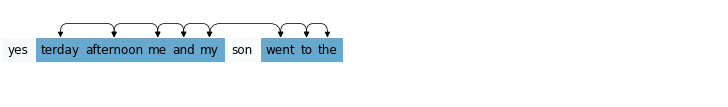

In [68]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="gym", top_k=k)

In [69]:
### EXPERIMENT 8

Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'
Analyzing interactions wrt prediction: ' library'


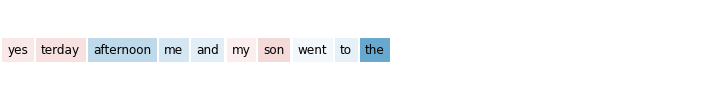

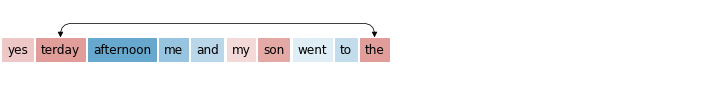

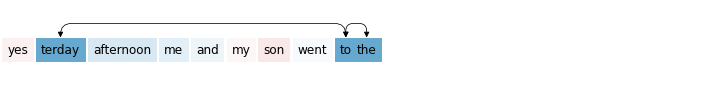

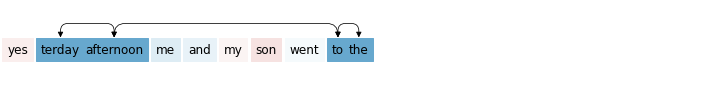

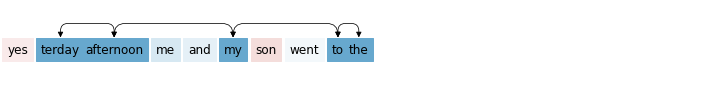

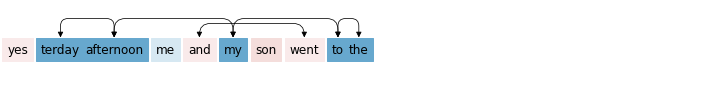

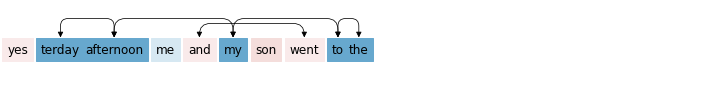

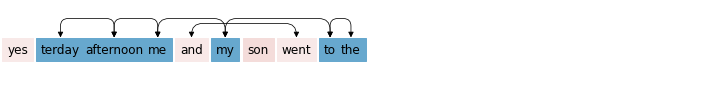

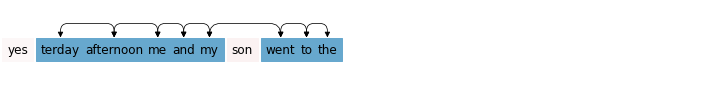

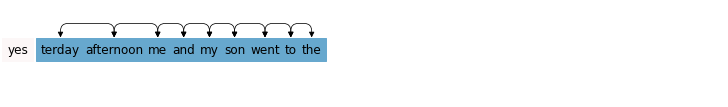

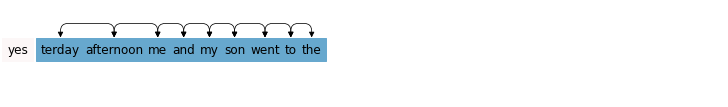

In [70]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="library", top_k=k)

In [71]:
### EXPERIMENT 9

Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'
Analyzing interactions wrt prediction: ' hospital'


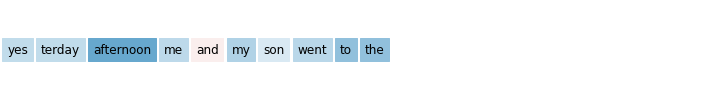

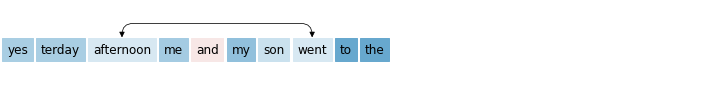

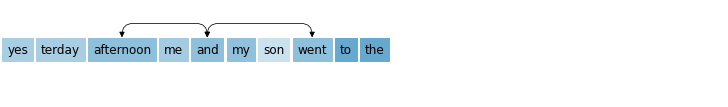

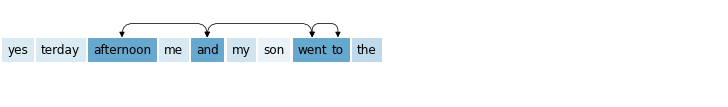

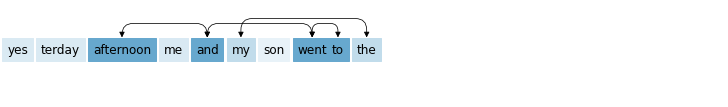

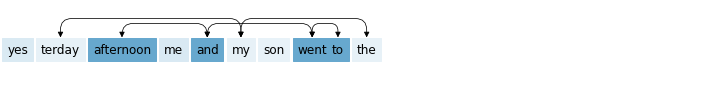

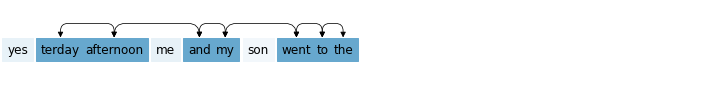

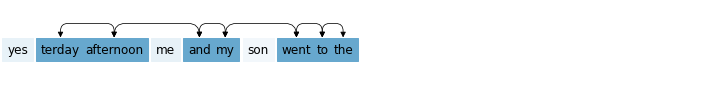

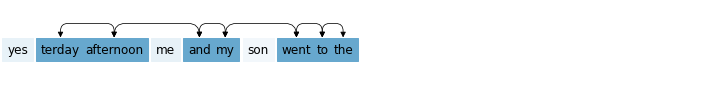

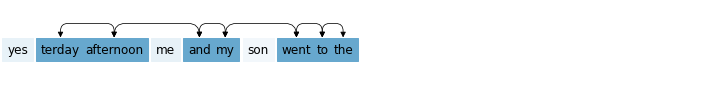

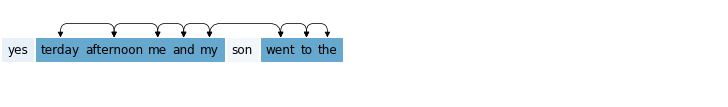

In [72]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="hospital", top_k=k)

In [73]:
### EXPERIMENT 10

Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'
Analyzing interactions wrt prediction: ' school'


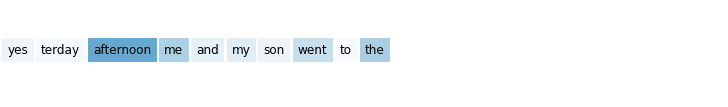

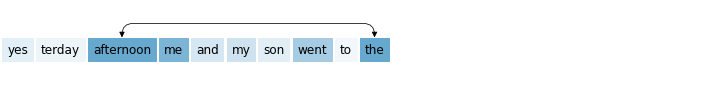

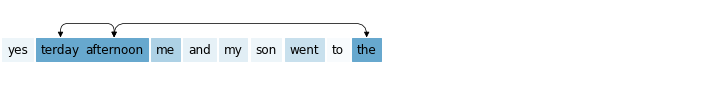

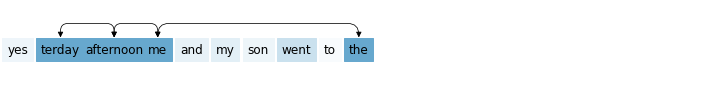

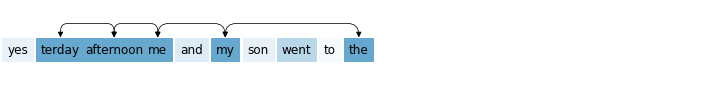

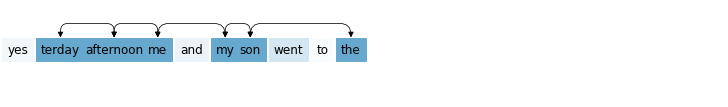

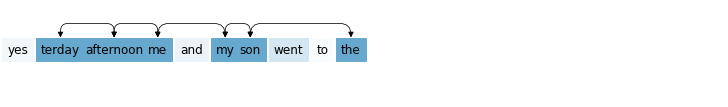

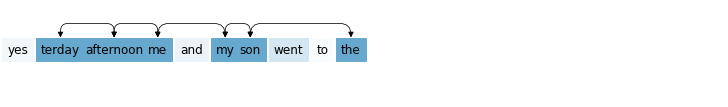

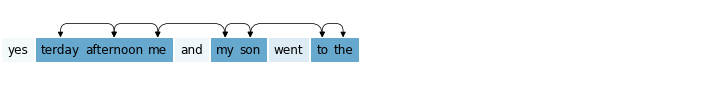

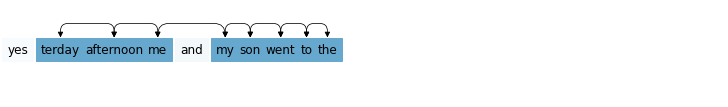

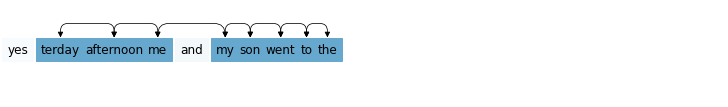

In [74]:
for k in range(num_tokens+1):
    explain_prediction(sent=sent, next_word="school", top_k=k)